In [1]:
from pathlib import Path
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix

from sklearn.metrics import classification_report


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train_date = pd.read_csv('C:/Users/wgkdj/smbc_comp/input/train.csv')
test_date = pd.read_csv('C:/Users/wgkdj/smbc_comp/input/test.csv')
sub_df = pd.read_csv('C:/Users/wgkdj/smbc_comp/input/sample_submission.csv',header=None)
sub_df.columns = ["index", "health"]

In [4]:
sub_df.shape

(19702, 2)

In [4]:
train_date.sample(5)

,Unnamed: 0,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
19538,19538,2015-10-05,18,OnCurb,0,1or2,NaN,Damage,Volunteer,NaN,sweetgum,Liquidambar styraciflua,QN46,Bayside-Bayside Hills,4,4109300,Queens,Bayside,411,11,26,19
2651,2651,2015-08-24,6,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,eastern redbud,Cercis canadensis,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4,4093800,Queens,Rockaway Park,414,15,23,32
14074,14074,2015-11-20,4,OnCurb,1,1or2,NaN,NoDamage,NYC Parks Staff,NaN,Japanese zelkova,Zelkova serrata,SI05,New Springville-Bloomfield-Travis,5,5027302,Staten Island,Staten Island,502,24,63,50
5428,5428,2015-08-15,3,OnCurb,1,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,Japanese zelkova,Zelkova serrata,SI24,Todt Hill-Emerson Hill-Heartland Village-Light...,5,5027900,Staten Island,Staten Island,502,24,62,50
3051,3051,2015-08-11,7,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,pin oak,Quercus palustris,MN33,East Harlem South,1,1016800,Manhattan,New York,111,30,68,8


In [54]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        X['created_at'] = pd.to_datetime(X['created_at'])
        X['created_at_year'] = X['created_at'].dt.year
        X['created_at_month'] = X['created_at'].dt.month
        X['created_at_day'] = X['created_at'].dt.day
        X['problems'].fillna(' ', inplace=True)
        X['problems'] = X['problems'].astype('category')
        problem = ["Stones", "BranchLights", "BranchOther", "RootOther", "TrunkOther", "WiresRope", "MetalGrates", "TrunkLights"]
        for substring in problem:
            X[substring] = X['problems'].apply(lambda row: 1 if substring in row else 0)
        return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")
        
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols
class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

In [59]:
import category_encoders as ce


# Assuming OriginalTransformer and PreProcessTransformer are defined

# Sample data

numeric_cols = [
    'tree_dbh',
    'borocode',
    'boro_ct',
    'cb_num',
    'st_senate',
    'st_assem',
    'cncldist',
    'created_at_year',
    'created_at_month',
    'created_at_day',
]
categorical_cols = [
    'curb_loc',
    'steward',
    'guards',
    'sidewalk',
    'user_type',
    #'problems',
    'Stones',
    'BranchLights',
    'BranchOther',
    'RootOther',
    'TrunkOther',
    'WiresRope',
    'MetalGrates',
    'TrunkLights',
]

# ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            numeric_cols + categorical_cols
        ),
        (
            "tgt",
            ce.TargetEncoder(cols=['curb_loc', 'steward', 'guards', 'sidewalk', 'user_type', 'problems',
                                   'spc_common', 'spc_latin', 'nta', 'nta_name', 'boroname', 'zip_city']),
            ['curb_loc', 'steward', 'guards', 'sidewalk', 'user_type', 'problems',
             'spc_common', 'spc_latin', 'nta', 'nta_name', 'boroname', 'zip_city']
        ),
    ],
    verbose=True
)

# Pipeline
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ('ct', ct),
    ]
)
# Fit and transform
train_feat_df = pipe.fit_transform(train_date, train_date['health'])
test_feat_df = pipe.transform(test_date)


[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.4s


In [21]:
train_feat_df.head()

,ori__tree_dbh,ori__borocode,ori__boro_ct,ori__cb_num,ori__st_senate,ori__st_assem,ori__cncldist,ori__created_at_year,ori__created_at_month,ori__created_at_day,ori__curb_loc,ori__steward,ori__guards,ori__sidewalk,ori__user_type,ori__problems,ori__Stones,ori__BranchLights,ori__BranchOther,ori__RootOther,ori__TrunkOther,ori__WiresRope,ori__MetalGrates,ori__TrunkLights,tgt__curb_loc,tgt__steward,tgt__guards,tgt__sidewalk,tgt__user_type,tgt__problems,tgt__spc_common,tgt__spc_latin,tgt__nta,tgt__nta_name,tgt__boroname,tgt__zip_city
0,14.0,4.0,4152901.0,411.0,11.0,25.0,23.0,2015.0,6.0,29.0,OnCurb,NaN,NaN,Damage,Volunteer,,0,0,0,0,0,0,0,0,0.858391,0.864207,0.870307,0.852717,0.849674,0.870130,0.815192,0.815192,0.905405,0.905405,0.858186,0.905405
1,5.0,2.0,2039901.0,207.0,33.0,78.0,15.0,2016.0,9.0,21.0,OnCurb,3or4,Helpful,NoDamage,Volunteer,,0,0,0,0,0,0,0,0,0.858391,0.857275,0.824110,0.862663,0.849674,0.870130,0.896296,0.896296,0.863810,0.863810,0.854626,0.854626
2,26.0,5.0,5017011.0,503.0,24.0,62.0,51.0,2015.0,9.0,13.0,OnCurb,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,1,1,0,0,0,0,0,0,0.858391,0.864207,0.870307,0.862663,0.849674,0.809711,0.815192,0.815192,0.836667,0.836667,0.861044,0.861044
3,15.0,5.0,5024401.0,503.0,24.0,62.0,51.0,2016.0,5.0,9.0,OnCurb,NaN,NaN,Damage,NYC Parks Staff,,0,0,0,0,0,0,0,0,0.858391,0.864207,0.870307,0.852717,0.863000,0.870130,0.852031,0.852031,0.888579,0.888579,0.861044,0.861044
4,23.0,1.0,1022102.0,110.0,30.0,70.0,9.0,2016.0,6.0,24.0,OnCurb,NaN,NaN,NoDamage,Volunteer,Stones,1,0,0,0,0,0,0,0,0.858391,0.864207,0.870307,0.862663,0.849674,0.826048,0.839070,0.839070,0.785010,0.785010,0.860577,0.858844


In [13]:
def plot_confusion_matrix(test_y, pred_y, class_names, normalize=False):
        cm = confusion_matrix(test_y, pred_y)
        classes = class_names
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=classes,
            yticklabels=classes,
            ylabel='True label\n',
            xlabel='\nPredicted label')
        fmt = '.2f' if normalize else 'd'
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center")
        fig.tight_layout()
        return ax

In [73]:
def get_statified_cv(df,y,n_fold=5):
    kf = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=2023)
    return list(kf.split(df,y))
def get_cv(df, n_fold=6):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    score_list_all = []
    models = []
    n_records = len(X)
    recall_list = []
    precision_list = []

    oof = np.zeros((n_records,), dtype=np.int32)
    for fold_, (train_index, valid_index) in enumerate(cv):
        train_x = X.iloc[train_index]
        valid_x = X.iloc[valid_index]
        train_y = y.iloc[train_index]
        valid_y = y.iloc[valid_index]
        gbm = lgb.LGBMClassifier(**params)
        gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],
                callbacks=[lgb.early_stopping(100, verbose=verbose)], )
        pred_i = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
        oof[valid_index] = pred_i
        score_list_all.append(round(f1_score(valid_y, pred_i, average='macro'), 4))
        recall_list.append(round(recall_score(valid_y, pred_i,average='macro'), 4))
        precision_list.append(round(precision_score(valid_y, pred_i,average='macro'), 4))
        models.append(gbm)  # Store the trained model in the list
        print(f'fold{fold_ + 1} end\n')
        print(score_list_all, 'f1_score', np.mean(score_list_all))
        print(precision_list, 'precision', np.mean(precision_list))
        print(recall_list, 'recall', np.mean(recall_list))
        plot_confusion_matrix(valid_y, pred_i,[0,1,2])
    return models, oof, gbm
def fit_lgbm2(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    score_list_all = []
    models = []
    n_records = len(X)
    recall_list = []
    precision_list = []
    recall_list_all=[]
    precision_list_all=[]
    oof = np.zeros((n_records,), dtype=np.int32)
    for fold_, (train_index, valid_index) in enumerate(cv):
        train_x = X.iloc[train_index]
        valid_x = X.iloc[valid_index]
        train_y = y.iloc[train_index]
        valid_y = y.iloc[valid_index]
        gbm = lgb.LGBMClassifier(**params)
        gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],
                
                callbacks=[lgb.early_stopping(100, verbose=verbose)], )
        pred_i = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
        oof[valid_index] = pred_i


        score_list_all.append(round(f1_score(valid_y, pred_i, average='macro'), 4))
        recall_list.append([round(recall_score(valid_y, pred_i, average='macro', labels=[label]), 4) for label in [0, 1, 2]])
        precision_list.append([round(precision_score(valid_y, pred_i, average='macro', labels=[label]), 4) for label in [0, 1, 2]])
        recall_list_all.append(round(recall_score(valid_y, pred_i,average='macro'), 4))
        precision_list_all.append(round(precision_score(valid_y, pred_i,average='macro'), 4))
        models.append(gbm)  # トレーニング済みモデルをリストに格納
        print(f'fold{fold_ + 1} end\n')
        print(score_list_all, 'f1_score', np.mean(score_list_all))
        print(recall_list_all,'recall_score_all',np.mean(recall_list_all))
        print(precision_list_all,'precision_score_all',np.mean(precision_list_all))
        print('recall',recall_list, '\nrecall_avg', np.mean(recall_list, axis=0))
        print('precision',precision_list, '\nprecision_avg', np.mean(precision_list, axis=0))
        plot_confusion_matrix(valid_y, pred_i, [0, 1, 2])

    return models, oof, gbm
def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax



[(array([    0,     1,     2, ..., 19981, 19982, 19983]), array([    3,    11,    14, ..., 19969, 19973, 19977])), (array([    0,     1,     2, ..., 19978, 19980, 19981]), array([    8,    10,    12, ..., 19979, 19982, 19983])), (array([    0,     1,     2, ..., 19981, 19982, 19983]), array([    4,     7,    13, ..., 19972, 19976, 19978])), (array([    1,     3,     4, ..., 19980, 19982, 19983]), array([    0,     2,     9, ..., 19964, 19970, 19981])), (array([    0,     2,     3, ..., 19981, 19982, 19983]), array([    1,     5,     6, ..., 19959, 19960, 19980]))]
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

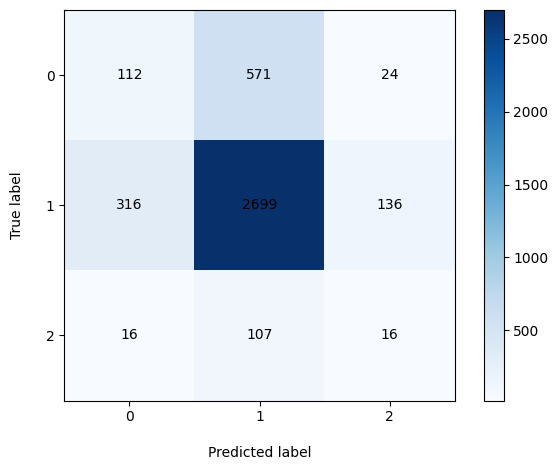

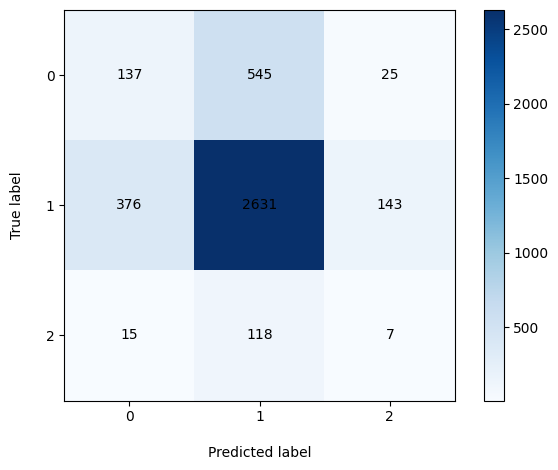

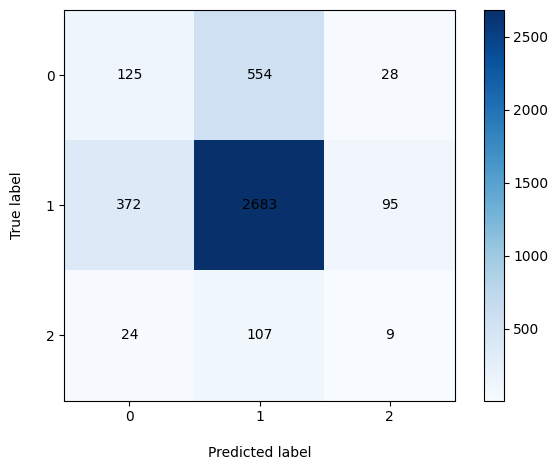

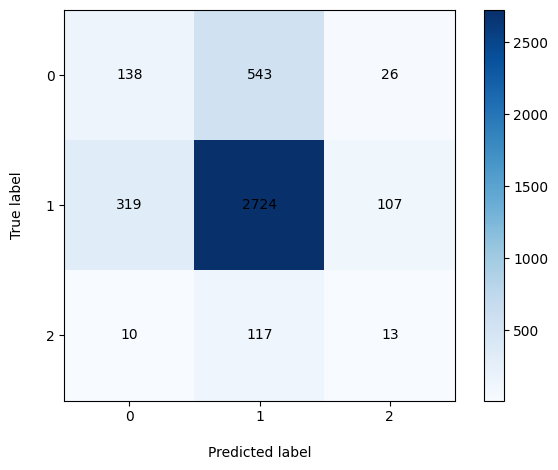

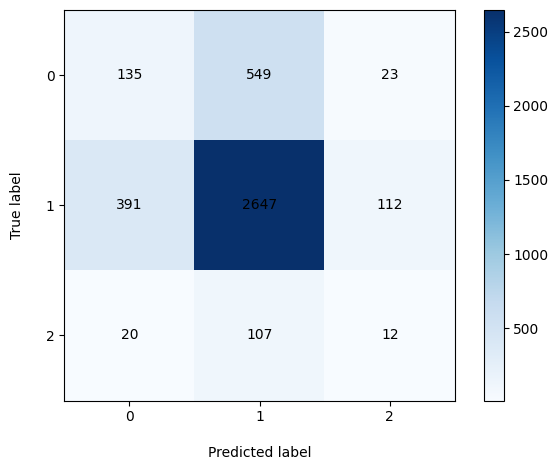

In [74]:
n_fold = 5
lgbm_params = {
    'objective': 'multiclass',
    'num_class': 3,  # クラスの数を指定
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'class_weight': {0: 3, 1: 1, 2: 12},#1以外の数値を上げるとreal１がより当該ラベルに落ちるようになる
    
}
# {'max_depth': 10, 'num_leaves': 878, 'colsample_bytree': 0.2694887336706078, 'subsample': 0.6660561803917702, 'class_weight_1': 2.5295377831337054}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_statified_cv(df=train_feat_df,y=train_date['health'], n_fold=5)
#cv = get_cv(df=train_feat_df,n_fold=5)
print(cv)
# training

models,oof,gbm = fit_lgbm2(
    train_feat_df,
    y=train_date["health"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

(<Figure size 1200x875 with 1 Axes>,
 <Axes: title={'center': 'Importance'}, xlabel='feature_importance', ylabel='column'>)

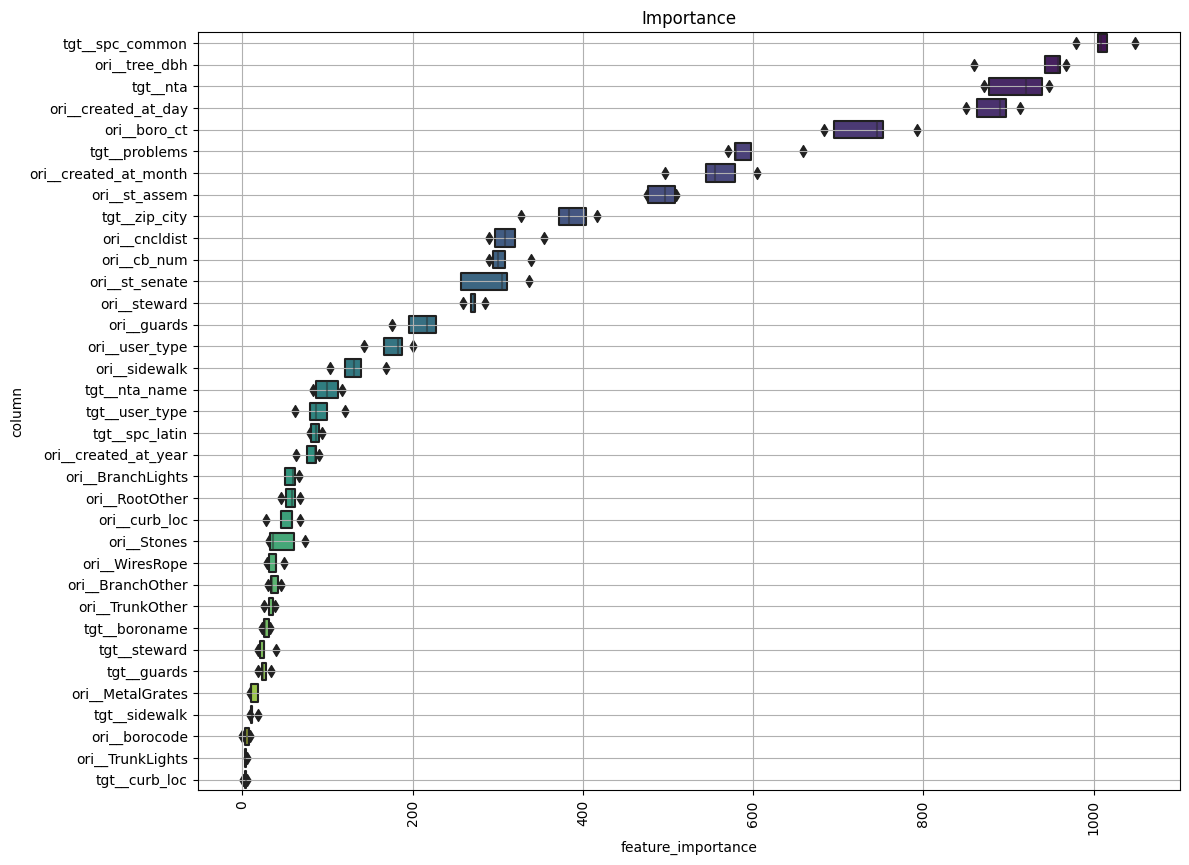

In [69]:
visualize_importance(models,train_feat_df)

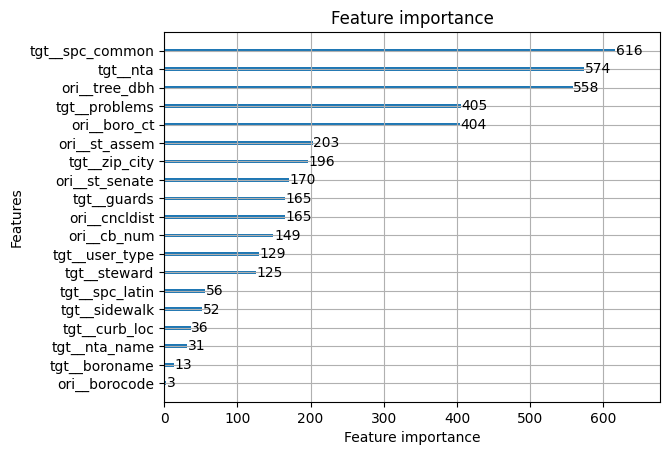

In [99]:
lgb.plot_importance(gbm)

# 新しい図を作成してサイズを調整
#plt.rcParams["figure.figsize"] = [30,30.0] # 幅10、高さ8の図を作成

# プロットを表示
plt.show()

In [151]:
sub_df.columns

Index([0, 1, '1'], dtype='object')

In [149]:
sub_df.sample(5)

,0,1
1553,21571,0
16215,36438,1
18576,38823,1
5647,25715,2
13651,33845,2


In [49]:
# inference
pred = np.array([model.predict_proba(test_feat_df) for model in models])
pred = np.mean(pred, axis=0)
pred_classes = np.argmax(pred, axis=1)  # 各サンプルにおいて確率が最も高いクラスを選択
# 3値分類に変更
pred_classes = pred_classes.astype(int)

# submission
sub_df["health"] = pred_classes
sub_df.to_csv("submission.csv", index=False, header=False)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
